In [11]:
# What is RAG

In [12]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File human-nutrition-text.pdf exists.


Opening the PDF file

In [13]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace('\n', " ").strip()

# Potentially more text formatting functions can go here...
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

1208it [00:01, 714.10it/s]


[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [14]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 890,
  'page_char_count': 1809,
  'page_word_count': 310,
  'page_sentence_count_raw': 21,
  'page_token_count': 452.25,
  'text': 'and tend to eat more meals away from home. Older adolescents  also can be curious and open to new ideas, which includes trying  new kinds of food and experimenting with their diet. For example,  teens will sometimes skip a main meal and snack instead. That is  not necessarily problematic. Their choice of food is more important  than the time or place.  However, too many poor choices can make young people  nutritionally vulnerable. Teens should be discouraged from eating  fast food, which has a high fat and sugar content, or frequenting  convenience stores and using vending machines, which typically  offer poor nutritional selections. Other challenges that teens may  face include obesity and eating disorders. At this life stage, young  people still need guidance from parents and other caregivers about  nutrition-related matters. It can be h

In [15]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [16]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


Token count is important here because:
Embedding models and  LLMs dont deal with infinite tokens.
For Example: An embedding model might have been trained to embed sequences of 384 tokens into numerical space.
LLMs also cannot accept infinite tokens in their context windows.

### Further Text Processing
Splitting pages into sentences.
There are two ways to do this:
1) Split sentences based on `"."` characters.
2) Using NLP libraries like spaCy and nltk.

In [17]:
from spacy.lang.en import English
nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. I like elephants")
assert len(list(doc.sents)) == 3

# print out our sentences split
list(doc.sents)

[This is a sentence., This is another sentence., I like elephants]

In [18]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

100%|██████████| 1208/1208 [00:02<00:00, 553.03it/s]


In [19]:
random.sample(pages_and_texts, k=1)

[{'page_number': 308,
  'page_char_count': 1568,
  'page_word_count': 288,
  'page_sentence_count_raw': 18,
  'page_token_count': 392.0,
  'text': 'fatty acids found in fish oil are proven to reduce the rate of  weight gain as compared to other fatty acids.1  Degrees of Saturation  Fatty acid chains are held together by carbon atoms that attach  to each other and to hydrogen atoms. The term saturation refers  to whether or not a fatty acid chain is filled (or “saturated”) to  capacity with hydrogen atoms. If each available carbon bond holds  a hydrogen atom we call this a saturated fatty acid chain. All carbon  atoms in such a fatty acid chain are bonded with single bonds.  Sometimes the chain has a place where hydrogen atoms are missing.  This is referred to as the point of unsaturation.  When one or more bonds between carbon atoms are a double  bond (C=C), that fatty acid is called an unsaturated fatty acid, as  it has one or more points of unsaturation. Any fatty acid that has  only

In [20]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking out sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.

There is no 100% correct way.

We'll keep it simple and split into groups of 10 sentences.

Why we do chunking?

- So our texts are easier to filter.
- So our text chunks can fit into our embedding model context window.
- So our contexts passed into the LLM can be more specific and focused.

In [21]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of text recursively into chunk size.
# e.g. [20] -> [10, 10] or [25] -> [10, 10, 5]

def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [22]:
# Loop through pages and text and sentences into chuncks
for item in tqdm(pages_and_texts):
    item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                                     slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])
    

100%|██████████| 1208/1208 [00:00<00:00, 418633.33it/s]


In [23]:
random.sample(pages_and_texts,k=1)

[{'page_number': 670,
  'page_char_count': 188,
  'page_word_count': 33,
  'page_sentence_count_raw': 2,
  'page_token_count': 47.0,
  'text': 'An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=384  \xa0 670  |  Copper',
  'sentences': ['An interactive or media element has been  excluded from this version of the text.',
   'You can  view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=384  \xa0 670  |  Copper'],
  'page_sentence_count_spacy': 2,
  'sentence_chunks': [['An interactive or media element has been  excluded from this version of the text.',
    'You can  view it online here:  http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=384  \xa0 670  |  Copper']],
  'num_chunks': 1}]

In [24]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32,1.53
std,348.86,560.44,95.75,6.19,140.11,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

Will provide more granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [25]:
import re

# Split each chunk into its own item
pages_and_chunks = []

for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like , aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A" (will work for any capital letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk


        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

100%|██████████| 1208/1208 [00:00<00:00, 28238.49it/s]


1843

In [26]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 212,
  'sentence_chunk': 'The Beverage Panel recommends an even lower intake of calories from beverages than IOM—10 percent or less of total caloric intake. Table 3.10 Recommendations of the Beverage Panel Beverage Servings per day* Water ≥ 4 (women), ≥ 6 (men) Unsweetened coffee and tea ≤ 8 for tea, ≤ 4 for coffee Nonfat and low-fat milk; fortified soy drinks ≤ 2 Diet beverages with sugar substitutes ≤ 4 100 percent fruit juices, whole milk, sports drinks ≤ 1 Calorie-rich beverages without nutrients ≤ 1, less if trying to lose weight *One serving is eight ounces. Source: Beverage Panel Recommendations and Analysis. University of North Carolina, Chapel Hill. US Beverage Guidance Council. http:/ /www.cpc.unc.edu/projects/nutrans/policy/beverage/us- beverage-panel. Accessed November 6, 2012. Sources of Drinking Water The Beverage Panel recommends that women drink at least 32 ounces and men drink at least 48 ounces of water daily. In 1974, the US federal government enacte

In [27]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filtering Shorter Chunks without much useful information

In [28]:
# Show random chunks with under 30 tokens in length
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 9.25 | Text: 490 | Factors Affecting Energy Intake
Chunk token count: 25.5 | Text: http:/ /pressbooks.oer.hawaii.edu/ humannutrition2/?p=521   996 | The Major Types of Foodborne Illness
Chunk token count: 25.25 | Text: http:/ /www.ncbi.nlm.nih.gov/ pubmed/3966752?dopt=Abstract. Accessed November 22, 2017. 618 | Calcium
Chunk token count: 28.0 | Text: https:/ /jamanetwork.com/journals/jama/ fullarticle/195531. Accessed October 5, 2017. 538 | Fat-Soluble Vitamins
Chunk token count: 29.5 | Text: Water As a Temperature Regulator Another homeostatic function of the body, termed 158 | Water’s Importance to Vitality


In [29]:
# Filter our DataFrame for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

### Embedding our text chunks

- We make use of the pretrained all-mpnet-base-v2 model for embedding.
- The all-mpnet-base-v2 model accepts 384 tokens in its context window. That means that it can embed an inpu with maximum of 384 tokens.

Note: No matter the size of the text input to our all-mpnet-base-v2 model, it will be turned into an embedding size of (768,). This value is fixed. So whether a sentence is 1 token long or 1000 tokens long, it will be truncated/padded with zeros to size 384 and then turned into an embedding vector of size (768,). Of course, other embedding models may have different input/output shapes.

In [30]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982920e-02  3.03164665e-02 -2.01217905e-02  6.86484948e-02
 -2.55256183e-02 -8.47686175e-03 -2.07220379e-04 -6.32377490e-02
  2.81606987e-02 -3.33353691e-02  3.02634146e-02  5.30721843e-02
 -5.03526852e-02  2.62288824e-02  3.33313867e-02 -4.51577231e-02
  3.63045000e-02 -1.37122965e-03 -1.20171504e-02  1.14946933e-02
  5.04510961e-02  4.70856875e-02  2.11914107e-02  5.14606237e-02
 -2.03746427e-02 -3.58889215e-02 -6.67792396e-04 -2.94393953e-02
  4.95859087e-02 -1.05639687e-02 -1.52014196e-02 -1.31761993e-03
  4.48197685e-02  1.56023400e-02  8.60379430e-07 -1.21391448e-03
 -2.37978976e-02 -9.09382768e-04  7.34482519e-03 -2.53931619e-03
  5.23370616e-02 -4.68043797e-02  1.66214909e-02  4.71579395e-02
 -4.15599421e-02  9.01963329e-04  3.60277593e-02  3.42214257e-02
  9.68226939e-02  5.94828986e-02 -1.64984427e-02 -3.51249315e-02
  5.92517108e-03 -7.07922853e-04 -2.4103

### Trying out with a GPU instead of a CPU to check the difference in time taken to make the embeddings.

In [33]:
!nvidia-smi

Thu Jul  4 15:12:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        Off | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8               6W /  50W |    605MiB /  4096MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cuda") # Trying with GPU to check the difference in speed.
# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981504e-02  3.03164888e-02 -2.01218370e-02  6.86483830e-02
 -2.55255606e-02 -8.47686082e-03 -2.07107194e-04 -6.32377192e-02
  2.81606559e-02 -3.33353356e-02  3.02634854e-02  5.30720800e-02
 -5.03526740e-02  2.62288265e-02  3.33313905e-02 -4.51578610e-02
  3.63044143e-02 -1.37113139e-03 -1.20171085e-02  1.14946915e-02
  5.04510514e-02  4.70856838e-02  2.11913399e-02  5.14607392e-02
 -2.03746408e-02 -3.58889252e-02 -6.67854794e-04 -2.94393208e-02
  4.95859347e-02 -1.05639845e-02 -1.52013563e-02 -1.31751702e-03
  4.48197052e-02  1.56023130e-02  8.60380169e-07 -1.21390400e-03
 -2.37978511e-02 -9.09380557e-04  7.34482007e-03 -2.53931060e-03
  5.23369908e-02 -4.68043461e-02  1.66214686e-02  4.71578799e-02
 -4.15599830e-02  9.01947962e-04  3.60278599e-02  3.42214629e-02
  9.68227461e-02  5.94828352e-02 -1.64984688e-02 -3.51249501e-02
  5.92515385e-03 -7.07960629e-04 -2.4103

Now we will use the embeddings model to create embeddings on our sentence chunks. Let's use the %%time to check the time taken as well.

In [34]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 1680/1680 [01:00<00:00, 27.98it/s]

CPU times: user 2min 45s, sys: 304 ms, total: 2min 45s
Wall time: 1min


GPU is significantly faster, but I think adding  the chunks into a single list will make the embedding process much more efficient.

In [35]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [36]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: user 1min 21s, sys: 146 ms, total: 1min 21s
Wall time: 1min 16s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

### Saving the generated embeddings to a file

In [37]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

Let's now see if we can import it.

In [38]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02281627e-02 -5.09549398e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52155897e-02 5.92139363e-02 -1.66167151e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801879e-02 3.39813977e-02 -2.06426699e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566836e-02 3.81274931e-02 -8.46854411e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264382e-02 -8.49767588e-03 9.57158953e-...


### RAG Part - Search and Answer

In [39]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [40]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242601, 0.0902281627, -0.00509549398, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552155897, 0.0592139363, -0.0166167151, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801879, 0.0339813977, -0.0206426699, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566836, 0.0381274931, -0.00846854411, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264382, -0.00849767588, 0.00957158953, ..."


In [41]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1671e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4905e-04, -9.9662e-02,  4.9

Reinstantiating the embeddings model

In [42]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

Let's now perfrom the semantic search, also known as vector search.
This helps find similar embedding vectors as compared to the one provided which helps in finding similar sentences.

In [43]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00149 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

Let's see, just as an experiment, how much time difference is created if we increase the size of embeddings by 100 times. 

In [44]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00270 seconds.


In [45]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [46]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

Let's print out the page where the first response is generated from.

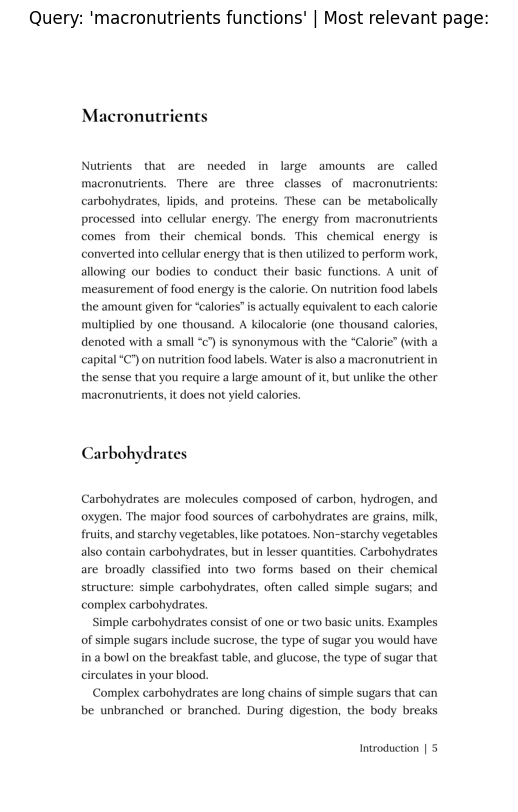

In [47]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Similarity Measures: Dot Product and Cosine Similarity
They are quite similar.

The main difference is that cosine similarity has a normalization step.

In [48]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

In [49]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [50]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [51]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th